# Anomaly Detection Models Implementations

In [24]:
import numpy as np
import pandas as pd
from river import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
import random
from river import anomaly
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from river import linear_model,ensemble
import collections
from river import stream
from sklearn.model_selection import train_test_split
from river import neighbors,tree
import os
from scipy.io import loadmat
from pyod.models.hbos import HBOS
from pysad.models.integrations import ReferenceWindowModel
from pysad.utils import ArrayStreamer
from pysad.transform.postprocessing import RunningAveragePostprocessor
from pysad.transform.preprocessing import InstanceUnitNormScaler, IdentityScaler, InstanceStandardScaler
from pysad.transform.probability_calibration import GaussianTailProbabilityCalibrator
from tqdm.notebook import tqdm_notebook
import pysad
import sklearn
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score
from imblearn.metrics import geometric_mean_score
from pysad.evaluation import AUROCMetric
from pysad.models import RobustRandomCutForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import math
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [25]:
actual_hst  =[]
pred_hst    =[] 
acc_hst=[]

actual_ocs  =[]
pred_ocs    =[]
acc_ocsvm=[]
        
# actual_arc  =[]
# pred_arc    =[]
            
actual_qnt  =[]
pred_qnt    =[]
acc_qf=[]

actual_thhst=[]
pred_thhst  =[]
acc_tf=[]

actual_rwm=[]
pred_rwm=[]
acc_hbos=[]

actual_es=[]
pred_es=[]
acc_kitnet=[]

actual_rbcf=[]
pred_rbcf=[]
acc_rrcf=[]

actual_ifa=[]
pred_ifa=[]
acc_ifsad=[]

actual_kcad=[]
pred_kcad=[]
acc_knncad=[]

auc_hst=metrics.ROCAUC()
auc_ocs=metrics.ROCAUC()
auc_arc=metrics.ROCAUC()
auc_qnt=metrics.ROCAUC()
auc_thhst=metrics.ROCAUC()
auc_knn=metrics.ROCAUC()
auc_rwm = AUROCMetric()
auc_es = AUROCMetric()
auc_rbcf = AUROCMetric()
auc_ifa = AUROCMetric()
auc_kcad = AUROCMetric()

gm_value_dict={}
stacked_auc={}

In [26]:
import pandas as pd
#df1=pd.read_csv("C:/Users/santosh/Desktop/Preprocess Dataset/Pollution_Final_data_8july.csv")
df1=pd.read_csv("C:/Users/santosh/OneDrive/Desktop/Preprocess Dataset/Pollution_Final_data_8july.csv")
timestamp=df1["Timestamp"]
x=df1.drop(['live','Timestamp','Average AQI'], axis=1)
y=df1['live']

# HST

In [27]:
def HST(da,datasetname=''):
     score_list_HST=[]
     # Creating pipeline for HST model
     model = compose.Pipeline(
          anomaly.HalfSpaceTrees(seed=42)
      )
     #setting up threshold for detection
     thresold=0.80 # for the old datasets 
     #thresold=0.0008 # For the Delhi Pollution dataset
     #initialinzing all Evaluation metrics
     global auc_hst
     score_gm = metrics.GeometricMean()
     score_recall = metrics.Recall()
     global actual_hst
     global pred_hst
     global gm_value_dict
     #looping over streaming data
     g_truth_HST=[]
     prediction_HST=[]
     for x, y in da:
          g_truth_HST.append(y)
          if(y==False):
              y=0
          if(y==True):
              y=1
          #print(y)
          
          score = model.score_one(x) # score for one each data input
          model = model.learn_one(x) # model learning from each data input
          score_list_HST.append(score)
          isAnamoly= 1 if score>thresold else 0 # detecting anamoly based on set thresold
          prediction_HST.append(isAnamoly)
          #print("score->",score,"pridction->",isAnamoly,"ground_truth->",y)
          actual_hst.append(y) # appending actual value for rocauc plot
          pred_hst.append(isAnamoly) # appedning pred value for rocauc plot
          auc_hst.update(y, isAnamoly) # updating AUC value metrics
          score_gm.update(y,isAnamoly) # updating Gm value metrics
          score_recall.update(y,isAnamoly) # updating Recall value metrics
     print('-------------------------------------'+datasetname+': HalfSpaceTree-------------------------------------------')
     accuracy = metrics.Accuracy()
     for yt, yp in zip(g_truth_HST, prediction_HST):
         acc_hst.append(accuracy.get())
         accuracy.update(yt, yp)
     print(accuracy)
     print('ROCAUC:{}'.format(round(auc_hst.get(),4)))
     print('Recall: {}'.format(score_recall.get()))
     print('Geometric Mean: {}'.format(score_gm.get()))
    
     #print(score_recall)
     #print(score_gm)
     gm_value_dict['HST']=round(score_gm.get()*100,2)
     return score_list_HST

In [5]:
# def HST(da, datasetname=''):
#     score_list_HST = []

#     # Adjusted HST parameters
#     model = compose.Pipeline(
#         anomaly.HalfSpaceTrees(n_trees=50, height=12, window_size=1000, seed=42)
#     )
    
#     threshold = 0.89  # Adjusted threshold (tune as needed)

#     global auc_hst, actual_hst, pred_hst, gm_value_dict
#     auc_hst = metrics.ROCAUC()  # Corrected the AUC metric
#     score_gm = metrics.GeometricMean()
#     score_recall = metrics.Recall()

#     g_truth_HST, prediction_HST = [], []

#     for x, y in da:
#         g_truth_HST.append(y)
#         y = int(y)  # Convert boolean labels to 0/1

#         score = model.score_one(x)  # Score the data point
#         model = model.learn_one(x)  # Learn from the data point
#         score_list_HST.append(score)

#         isAnomaly = 1 if score > threshold else 0
#         prediction_HST.append(isAnomaly)

#         actual_hst.append(y)
#         pred_hst.append(isAnomaly)

#         # Update metrics
#         auc_hst.update(y, isAnomaly)
#         score_gm.update(y, isAnomaly)
#         score_recall.update(y, isAnomaly)

#     # Calculate final metrics
#     accuracy = metrics.Accuracy()
#     for yt, yp in zip(g_truth_HST, prediction_HST):
#         accuracy.update(yt, yp)

#     print('-------------------------------------' + datasetname + ': HalfSpaceTree-------------------------------------------')
#     print(f'Accuracy: {accuracy.get():.2%}')
#     print(f'ROCAUC: {round(auc_hst.get(), 4)}')
#     print(f'Recall: {score_recall.get()}')
#     print(f'Geometric Mean: {score_gm.get()}')

#     gm_value_dict['HST'] = round(score_gm.get() * 100, 2)
#     return score_list_HST


In [28]:
score_list_HST=HST(stream.iter_array(np.array(x),np.array(y)),'Pollution_Final_data_8july.csv')

-------------------------------------Pollution_Final_data_8july.csv: HalfSpaceTree-------------------------------------------
Accuracy: 73.16%
ROCAUC:0.4929
Recall: 0.009472259810554804
Geometric Mean: 0.09616583223098837


In [7]:
import datetime
X_hst = [datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamp]
Y_hst = score_list_HST

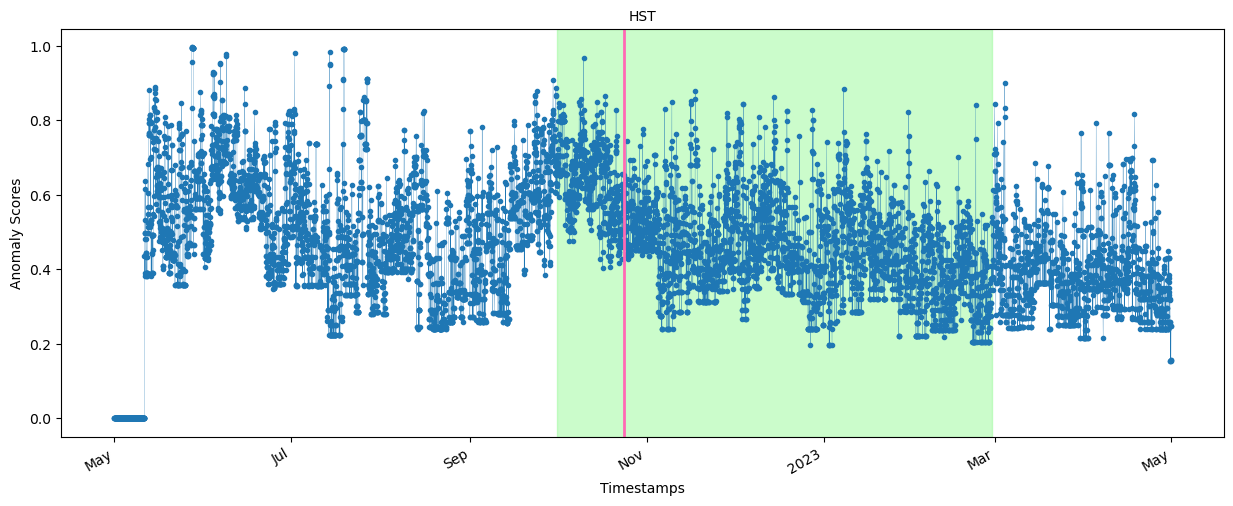

In [8]:
# Create the plot
import matplotlib.dates as mdates 
plt.figure(figsize=(15, 6))  # Increase the width of the plot
plt.plot(X_hst, Y_hst, linestyle='-',marker='.', linewidth=0.2)  # Decrease line width for better visibility

# # Highlighting 5th October for Dussherah with a yellow vertical line
# dussherah_date = '2022-10-05'
# dussherah_timestamp = mdates.datestr2num(dussherah_date)
# plt.axvline(x=dussherah_timestamp, color='yellow', linestyle='-', linewidth=2)

# Highlighting 24th October for Diwali with a red vertical line
diwali_date = '2022-10-24'
diwali_timestamp = mdates.datestr2num(diwali_date)
plt.axvline(x=diwali_timestamp, color='hotpink', linestyle='-', linewidth=2)

# Highlighting the stubble burning timestamp with a light green background
start_date = '2022-10-01'
end_date = '2023-02-28'
start_timestamp = mdates.datestr2num(start_date) 
end_timestamp = mdates.datestr2num(end_date)      

plt.axvspan(start_timestamp, end_timestamp, color='palegreen', alpha=0.5, label='1st Oct - 28th Feb')

# Format the x-axis for dates
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)  # Adjust the number of ticks for better readability
formatter = mdates.ConciseDateFormatter(locator)

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Set labels and title
plt.xlabel('Timestamps')
plt.ylabel('Anomaly Scores')
plt.title('HST', fontsize=10)

# Show the plot
plt.show()

# QF_OCSVM

In [9]:
def OCS(da,datasetname=''):
    score_list_OCSVM=[]
    #da=datasets.CreditCard().take(30000)
    model = anomaly.QuantileFilter(
         anomaly.OneClassSVM(nu=100),
         #q=0.95
         q=0.69
     )
    global auc_ocs 
    score_gm = metrics.GeometricMean()
    score_recall = metrics.Recall()
    #thresold=0.85
    global actual_ocs
    global pred_ocs
    global gm_value_dict
    
    g_truth_OCSVM=[]
    prediction_OCSVM=[]
    
    for x, y in da:
         #print(type(y))
         #break
         g_truth_OCSVM.append(y)
         if(y==False):
             y=0
         if(y==True):
             y=1
             
         score = model.score_one(x)
         score_list_OCSVM.append(score)
         is_anomaly = model.classify(score)
         model = model.learn_one(x)
         prediction_OCSVM.append(is_anomaly)
         actual_ocs.append(y)
         pred_ocs.append(score)
         auc_ocs = auc_ocs.update(y, is_anomaly)
         score_gm=score_gm.update(y,is_anomaly)
         score_recall=score_recall.update(y,is_anomaly)
    print('-------------------------------------'+datasetname+': OneClassSVM-------------------------------------------')
    accuracy = metrics.Accuracy()
    for yt, yp in zip(g_truth_OCSVM, prediction_OCSVM):
        acc_ocsvm.append(accuracy.get())
        accuracy.update(yt, yp)
    print(accuracy)
    print('ROCAUC:{}'.format(round(auc_ocs.get(),4)))
    print(score_recall)
    print(score_gm)
    gm_value_dict['QF_OCSVM']=round(score_gm.get()*100,2)
    return score_list_OCSVM/max(score_list_OCSVM)

In [10]:
score_list_OCSVM=OCS(stream.iter_array(np.array(x),np.array(y)),'Pollution_Final_data_8july.csv')

-------------------------------------Pollution_Final_data_8july.csv: OneClassSVM-------------------------------------------
Accuracy: 87.04%
ROCAUC:0.8603
Recall: 83.99%
GeometricMean: 86.01%


In [11]:
import datetime
X_OCSVM = [datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamp]
Y_OCSVM = score_list_OCSVM

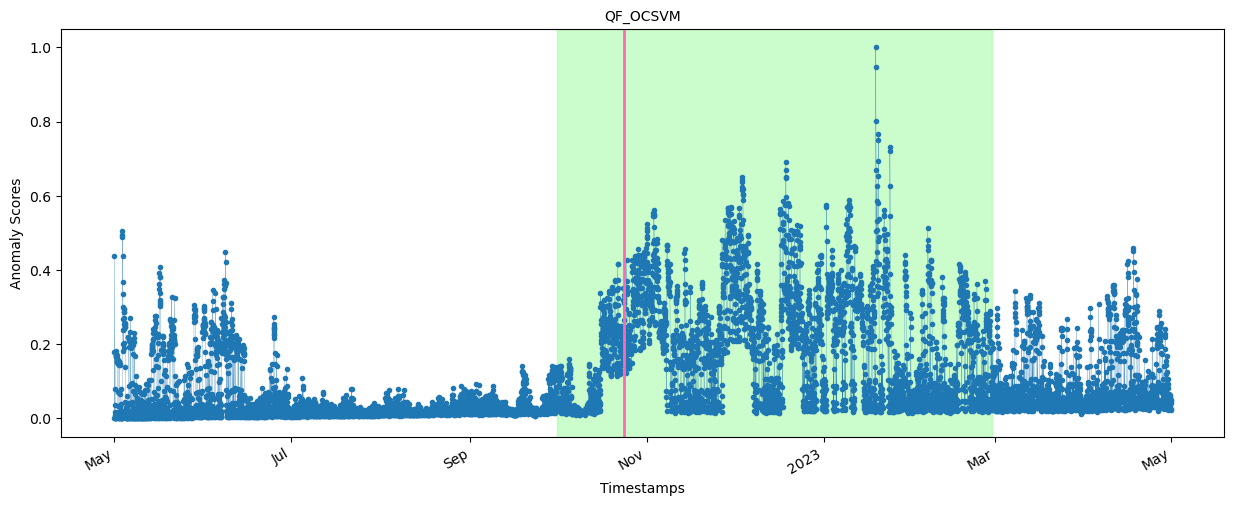

In [12]:
# Create the plot
import matplotlib.dates as mdates 
plt.figure(figsize=(15, 6))  # Increase the width of the plot
plt.plot(X_OCSVM, Y_OCSVM, linestyle='-',marker='.', linewidth=0.2)  # Decrease line width for better visibility

# Highlighting 24th October for Diwali with a red vertical line
diwali_date = '2022-10-24'
diwali_timestamp = mdates.datestr2num(diwali_date)
plt.axvline(x=diwali_timestamp, color='hotpink', linestyle='-', linewidth=2)

# Highlighting the stubble burning timestamp with a light green background
start_date = '2022-10-01'
end_date = '2023-02-28'
start_timestamp = mdates.datestr2num(start_date) 
end_timestamp = mdates.datestr2num(end_date)      

plt.axvspan(start_timestamp, end_timestamp, color='palegreen', alpha=0.5, label='1st Oct - 28th Feb')

# Format the x-axis for dates
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)  # Adjust the number of ticks for better readability
formatter = mdates.ConciseDateFormatter(locator)

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Set labels and title
plt.xlabel('Timestamps')
plt.ylabel('Anomaly Scores')
plt.title('QF_OCSVM', fontsize=10)

# Show the plot
plt.show()

# QF_HST

In [13]:
def QF(da,datasetname=''):
    score_list_QF=[]
    model = compose.Pipeline(
         preprocessing.StandardScaler(),
         anomaly.QuantileFilter(
             anomaly.HalfSpaceTrees(seed=42),
             #q=0.95 # for the old datasets
             q=0.58 #for the Delhi pollution datasets
         )
     )
    
    global auc_qnt
    score_gm = metrics.GeometricMean()
    score_recall = metrics.Recall()
    #thresold=0.75
    global actual_qnt
    global pred_qnt
    global gm_value_dict
    
    g_truth_QF=[]
    prediction_QF=[]
    
    for x, y in da:
         g_truth_QF.append(y)
         if(y==False):
             y=0
         if(y==True):
             y=1
         score = model.score_one(x)
         model = model.learn_one(x)
         score_list_QF.append(score)
         is_anomaly = model['QuantileFilter'].classify(score)
         prediction_QF.append(is_anomaly)
         actual_qnt.append(y)
         pred_qnt.append(score)
         #print(score)
         score_gm=score_gm.update(y,is_anomaly)
         score_recall=score_recall.update(y,is_anomaly)
         auc_qnt = auc_qnt.update(y, is_anomaly)
    print('-------------------------------------'+datasetname+': QuantileFilter-------------------------------------------')
    accuracy = metrics.Accuracy()
    for yt, yp in zip(g_truth_QF, prediction_QF):
        acc_qf.append(accuracy.get())
        accuracy.update(yt, yp)
    print(accuracy)
    print('ROCAUC:'+str(round(auc_qnt.get(),4)))
    print(score_recall)
    print(score_gm)
    gm_value_dict['QF_HST']=round(score_gm.get()*100,2)
    return score_list_QF

In [14]:
score_list_QF=QF(stream.iter_array(np.array(x),np.array(y)),'Pollution_Final_data_8july.csv')

-------------------------------------Pollution_Final_data_8july.csv: QuantileFilter-------------------------------------------
Accuracy: 69.71%
ROCAUC:0.7931
Recall: 98.74%
GeometricMean: 76.89%


In [15]:
import datetime
X_QF = [datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamp]
Y_QF = score_list_QF

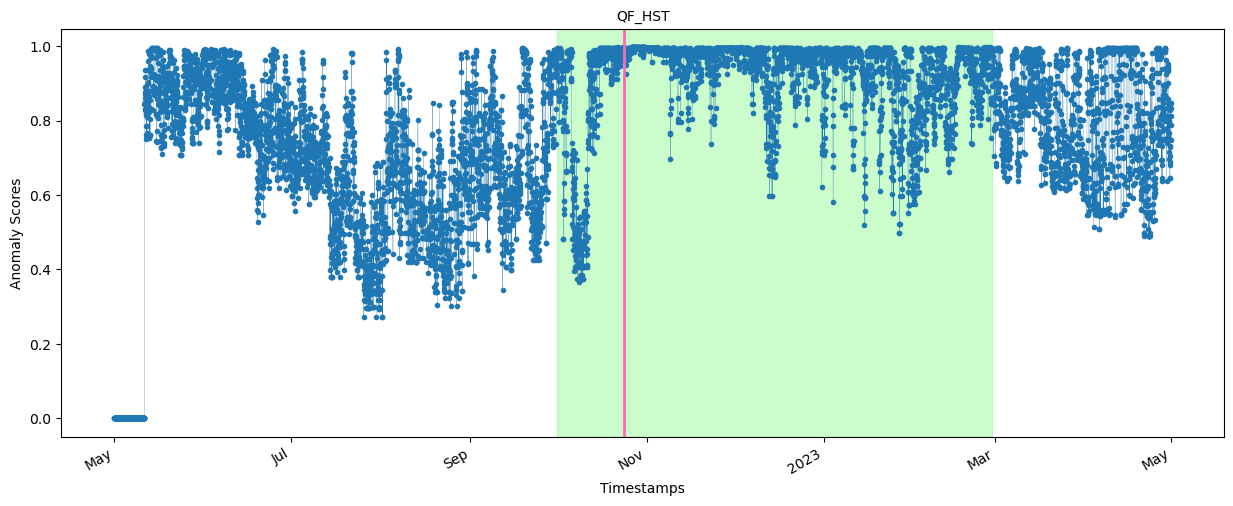

In [16]:
# Create the plot
import matplotlib.dates as mdates 
plt.figure(figsize=(15, 6))  # Increase the width of the plot
plt.plot(X_QF, Y_QF, linestyle='-',marker='.', linewidth=0.2)  # Decrease line width for better visibility

# Highlighting 24th October for Diwali with a red vertical line
diwali_date = '2022-10-24'
diwali_timestamp = mdates.datestr2num(diwali_date)
plt.axvline(x=diwali_timestamp, color='hotpink', linestyle='-', linewidth=2)

# Highlighting the stubble burning timestamp with a light green background
start_date = '2022-10-01'
end_date = '2023-02-28'
start_timestamp = mdates.datestr2num(start_date) 
end_timestamp = mdates.datestr2num(end_date)      

plt.axvspan(start_timestamp, end_timestamp, color='palegreen', alpha=0.5, label='1st Oct - 28th Feb')

# Format the x-axis for dates
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)  # Adjust the number of ticks for better readability
formatter = mdates.ConciseDateFormatter(locator)

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Set labels and title
plt.xlabel('Timestamps')
plt.ylabel('Anomaly Scores')
plt.title('QF_HST', fontsize=10)

# Show the plot
plt.show()

# TF_HST

In [17]:
def TF(da,datasetname=''):
    score_list_TF=[]
    #da=datasets.CreditCard().take(30000)
    model = (
         anomaly.ThresholdFilter(
         anomaly.HalfSpaceTrees(),
         threshold=0.99
         )
     )
    
    thresold=0.95 # for the old dataset 
    #thresold=.0008 # for Delhi dataset
    global auc_thhst 
    score_gm = metrics.GeometricMean()
    score_recall = metrics.Recall()
    global actual_thhst
    global pred_thhst
    global gm_value_dict

    g_truth_TF=[]
    prediction_TF=[]
    for x, y in da:
         #print(type(y))
         #break
         g_truth_TF.append(y)
         if(y==False):
             y=0
         if(y==True):
             y=1
         model = model.learn_one(x)
         score = model.score_one(x)
         score_list_TF.append(score)
         isAnamoly= 1 if score>thresold else 0
         prediction_TF.append(isAnamoly)
         actual_thhst.append(y)
         pred_thhst.append(score)
         auc_thhst = auc_thhst.update(y, isAnamoly)
         score_gm=score_gm.update(y,isAnamoly)
         score_recall=score_recall.update(y,isAnamoly)
    print('-------------------------------------'+datasetname+': ThresoldFilter-------------------------------------------')
    accuracy = metrics.Accuracy()
    for yt, yp in zip(g_truth_TF, prediction_TF):
        acc_tf.append(accuracy.get())
        accuracy.update(yt, yp)
    print(accuracy)
    print('ROCAUC:'+str(round(auc_thhst.get(),4)))
    print(score_recall)
    print(score_gm)
    gm_value_dict['TF_HST']=round(score_gm.get()*100,2)
    return score_list_TF
    

In [18]:
score_list_TF=TF(stream.iter_array(np.array(x),np.array(y)),'Pollution_Final_data_8july.csv')

-------------------------------------Pollution_Final_data_8july.csv: ThresoldFilter-------------------------------------------
Accuracy: 74.38%
ROCAUC:0.4979
Recall: 0.00%
GeometricMean: 0.00%


In [19]:
import datetime
X_TF = [datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamp]
Y_TF = score_list_TF

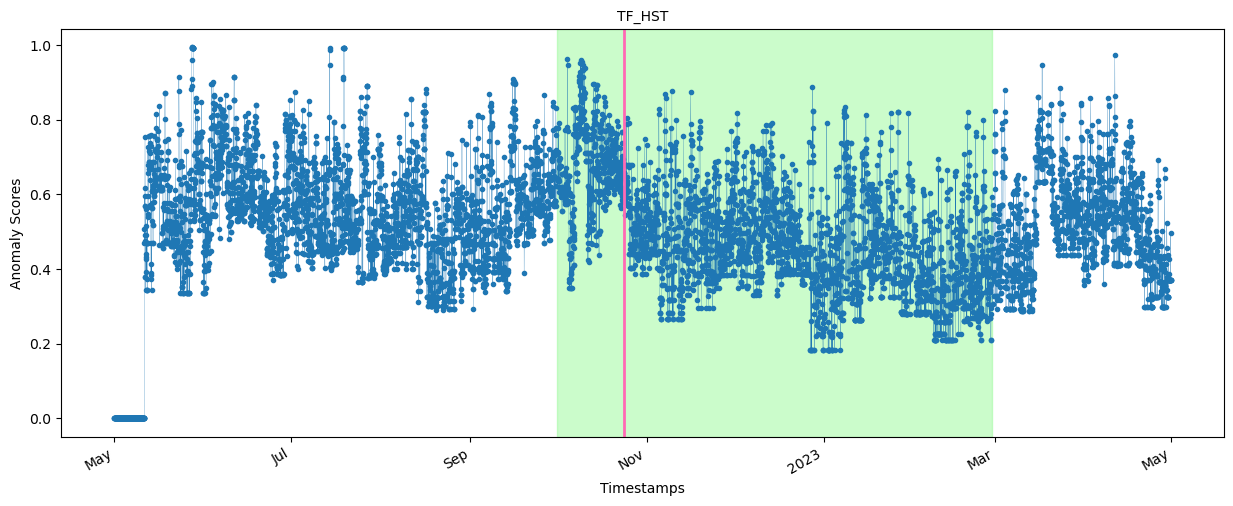

In [20]:
# Create the plot
import matplotlib.dates as mdates 
plt.figure(figsize=(15, 6))  # Increase the width of the plot
plt.plot(X_TF, Y_TF, linestyle='-',marker='.', linewidth=0.2)  # Decrease line width for better visibility

# Format the x-axis for dates
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)  # Adjust the number of ticks for better readability
formatter = mdates.ConciseDateFormatter(locator)

# Highlighting 24th October for Diwali with a red vertical line
diwali_date = '2022-10-24'
diwali_timestamp = mdates.datestr2num(diwali_date)
plt.axvline(x=diwali_timestamp, color='hotpink', linestyle='-', linewidth=2)

# Highlighting the stubble burning timestamp with a light green background
start_date = '2022-10-01'
end_date = '2023-02-28'
start_timestamp = mdates.datestr2num(start_date) 
end_timestamp = mdates.datestr2num(end_date)      

plt.axvspan(start_timestamp, end_timestamp, color='palegreen', alpha=0.5, label='1st Oct - 28th Feb')

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Set labels and title
plt.xlabel('Timestamps')
plt.ylabel('Anomaly Scores')
plt.title('TF_HST', fontsize=10)

# Show the plot
plt.show()

# HBOS

In [21]:
def RWM(da,datasetname=''):
    score_list_HBOS=[]
    model1 = ReferenceWindowModel(model_cls=HBOS, window_size=500, sliding_size=200) # Model initialization
    preprocessor = InstanceUnitNormScaler()  # Normalizer
    postprocessor = RunningAveragePostprocessor(window_size=500)  # Running average postprocessor
    calibrator = GaussianTailProbabilityCalibrator(running_statistics=True, window_size=6400)

    global auc_rwm
    auc_rwm = AUROCMetric()
    score_gm = metrics.GeometricMean()
    score_recall = metrics.Recall()
    global actual_rwm
    global pred_rwm
    global gm_value_dict
    
    for x, y in da:
         if(y==False):
             y=0
         if(y==True):
             y=1
             
         values = list(x.values())
         numpy_array = np.array(values)
         X = preprocessor.fit_transform_partial(numpy_array)
         X = [0 if math.isnan(x) else x for x in X]
         anomaly_score = model1.fit_score_partial(X)    
         anomaly_score1 = postprocessor.fit_transform_partial(anomaly_score)
         calibrated_score1 = calibrator.fit_transform_partial(anomaly_score1)
         score_list_HBOS.append(-anomaly_score)
         auc_rwm.update(y, calibrated_score1)
         
         
         if(calibrated_score1>0.5):
             pred_rwm.append(0)
         else:
             pred_rwm.append(1)
         actual_rwm.append(y)

    #print(score)
    score_gm=geometric_mean_score(np.array(actual_rwm),np.array(pred_rwm))
    score_recall=recall_score(np.array(actual_rwm),np.array(pred_rwm))
    auc_rwm = round(sklearn.metrics.roc_auc_score(np.array(actual_rwm),np.array(pred_rwm)),4)
    print('-------------------------------------'+datasetname+': ReferenceWindowModel-------------------------------------------')
    accuracy = metrics.Accuracy()
    for yt, yp in zip(actual_rwm, pred_rwm):
        acc_hbos.append(accuracy.get())
        accuracy.update(yt, yp)
    print(accuracy)
    print('ROCAUC:'+str(auc_rwm))
    print(score_recall)
    print(score_gm)
    gm_value_dict['HBOS']=round(score_gm*100,2)
    #print(type(score_list_HBOS),type(max(score_list_HBOS)),max(score_list_HBOS))
    return score_list_HBOS/np.float64(max(score_list_HBOS))
    return score_list_HBOS/(max(score_list_HBOS))

In [22]:
score_list_HBOS=RWM(stream.iter_array(np.array(x),np.array(y)),'Pollution_Final_data_8july.csv')

-------------------------------------Pollution_Final_data_8july.csv: ReferenceWindowModel-------------------------------------------
Accuracy: 74.36%
ROCAUC:0.7547
0.7771763644564728
0.7543700147993222


In [23]:
import datetime
X_HBOS = [datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamp]
Y_HBOS= score_list_HBOS

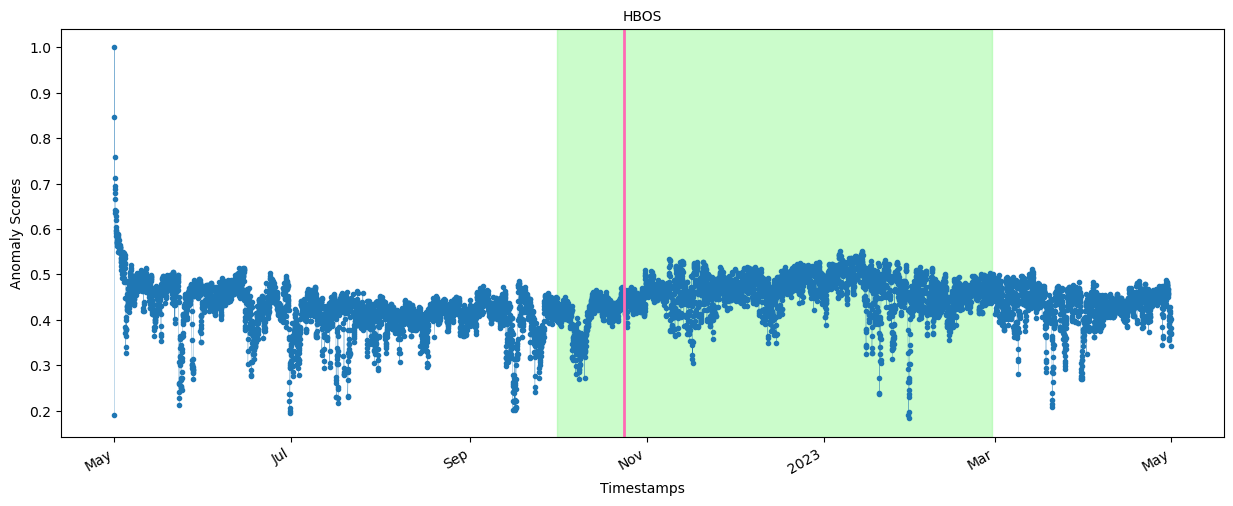

In [24]:
# Create the plot
import matplotlib.dates as mdates 
plt.figure(figsize=(15, 6))  # Increase the width of the plot
plt.plot(X_HBOS, Y_HBOS, linestyle='-',marker='.', linewidth=0.2)  # Decrease line width for better visibility

# Highlighting 24th October for Diwali with a red vertical line
diwali_date = '2022-10-24'
diwali_timestamp = mdates.datestr2num(diwali_date)
plt.axvline(x=diwali_timestamp, color='hotpink', linestyle='-', linewidth=2)

# Highlighting the stubble burning timestamp with a light green background
start_date = '2022-10-01'
end_date = '2023-02-28'
start_timestamp = mdates.datestr2num(start_date) 
end_timestamp = mdates.datestr2num(end_date)      

plt.axvspan(start_timestamp, end_timestamp, color='palegreen', alpha=0.5, label='1st Oct - 28th Feb')

# Format the x-axis for dates
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)  # Adjust the number of ticks for better readability
formatter = mdates.ConciseDateFormatter(locator)

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Set labels and title
plt.xlabel('Timestamps')
plt.ylabel('Anomaly Scores')
plt.title('HBOS', fontsize=10)

# Show the plot
plt.show()

# KitNet

In [25]:
# def KitNet(da,datasetname=''):
#     score_list_KitNet=[]
#     model1 = pysad.models.KitNet(max_size_ae=10, grace_feature_mapping=None, grace_anomaly_detector=50000, learning_rate=0.1, hidden_ratio=0.75) # Model initialization
#     preprocessor = InstanceUnitNormScaler()  # Normalizer
#     postprocessor = RunningAveragePostprocessor(window_size=500)  # Running average postprocessor
#     calibrator = GaussianTailProbabilityCalibrator(running_statistics=True, window_size=6400)

#     global auc_es
#     auc_es = AUROCMetric()
#     score_gm = metrics.GeometricMean()
#     score_recall = metrics.Recall()
#     global actual_es
#     global pred_es
#     global gm_value_dict
    
#     for x, y in da:
#          if(y==False):
#              y=0
#          if(y==True):
#              y=1
#          values = list(x.values())
#          numpy_array = np.array(values)
#          X = preprocessor.fit_transform_partial(numpy_array)
#          anomaly_score = model1.fit_score_partial(X)    
#          anomaly_score1 = postprocessor.fit_transform_partial(anomaly_score)
#          calibrated_score1 = calibrator.fit_transform_partial(anomaly_score1)
#          score_list_KitNet.append(calibrated_score1)
#          #print(anomaly_score,anomaly_score1,calibrated_score1)
         
         
#          if(calibrated_score1>0.05):
#              pred_es.append(0)
#          else:
#              pred_es.append(1)
#          actual_es.append(y)
#          auc_es.update(y, pred_es[-1])

#     score_gm=geometric_mean_score(np.array(actual_es),np.array(pred_es))
#     score_recall=recall_score(np.array(actual_es),np.array(pred_es))
#     auc_es = round(sklearn.metrics.roc_auc_score(np.array(actual_es),np.array(pred_es)),4)
#     print('-------------------------------------'+datasetname+': KitNet-------------------------------------------')
#     accuracy = metrics.Accuracy()
#     for yt, yp in zip(actual_es, pred_es):
#         acc_kitnet.append(accuracy.get())
#         accuracy.update(yt, yp)
#     print(accuracy)
#     print('ROCAUC:'+str(auc_es))
#     print(score_recall)
#     print(score_gm)
#     gm_value_dict['KitNet']=round(score_gm*100,2)
#     return score_list_KitNet

In [26]:
from sklearn.preprocessing import MinMaxScaler

def KitNet(da,datasetname=''):
    score_list_KitNet=[]
    #model1 = pysad.models.KitNet(max_size_ae=10, grace_feature_mapping=None, grace_anomaly_detector=50000, learning_rate=0.1, hidden_ratio=0.75) # Model initialization
    model1 = pysad.models.KitNet(
    max_size_ae=20,
    grace_feature_mapping=5000,
    grace_anomaly_detector=10000,
    learning_rate=0.05,
    hidden_ratio=0.9
    )
    preprocessor = InstanceUnitNormScaler()  # Normalizer
    #preprocessor = InstanceStandardScaler()
    
    #postprocessor = RunningAveragePostprocessor(window_size=500)  # Running average postprocessor
    postprocessor = RunningAveragePostprocessor(window_size=1000)
    #calibrator = GaussianTailProbabilityCalibrator(running_statistics=True, window_size=6400)
    calibrator = GaussianTailProbabilityCalibrator(running_statistics=True, window_size=10000)

    global auc_es
    auc_es = AUROCMetric()
    score_gm = metrics.GeometricMean()
    score_recall = metrics.Recall()
    global actual_es
    global pred_es
    global gm_value_dict

    scaler = MinMaxScaler(feature_range=(0,1))
    
    for x, y in da:
         if(y==False):
             y=0
         if(y==True):
             y=1
         # print("x : ", x)
         values = list(x.values())
         # print("values : ", values)
         numpy_array = np.array(values)
         # numpy_array = scaler.fit_transform(numpy_array.reshape(-1, 1))
         # numpy_array = numpy_array.flatten()
         X = preprocessor.fit_transform_partial(numpy_array)
         # # print(X.shape)
         # X = scaler.fit_transform(X.reshape(-1, 1))
         # X = X.flatten()
         # print("X : ", X)
         anomaly_score = model1.fit_score_partial(X)    
         anomaly_score1 = postprocessor.fit_transform_partial(anomaly_score)
         calibrated_score1 = calibrator.fit_transform_partial(anomaly_score1)
         # print("anomaly score : ", anomaly_score)
         score_list_KitNet.append(values)
         #print(anomaly_score,anomaly_score1,calibrated_score1)
         
         if(calibrated_score1>0.05):
             pred_es.append(0)
         else:
             pred_es.append(1)
         actual_es.append(y)
         auc_es.update(y, pred_es[-1])

    score_gm=geometric_mean_score(np.array(actual_es),np.array(pred_es))
    score_recall=recall_score(np.array(actual_es),np.array(pred_es))
    auc_es = round(sklearn.metrics.roc_auc_score(np.array(actual_es),np.array(pred_es)),4)
    print('-------------------------------------'+datasetname+': KitNet-------------------------------------------')
    accuracy = metrics.Accuracy()
    for yt, yp in zip(actual_es, pred_es):
        acc_kitnet.append(accuracy.get())
        accuracy.update(yt, yp)
    print(accuracy)
    print('ROCAUC:'+str(auc_es))
    print(score_recall)
    print(score_gm)
    gm_value_dict['KitNet']=round(score_gm*100,2)
    return score_list_KitNet

In [27]:
score_list_KitNet=KitNet(stream.iter_array(np.array(x),np.array(y)),'Pollution_Final_data_8july.csv')

import datetime
X_KitNet = [datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamp]
Y_KitNet= score_list_KitNet
# Y_KitNet_normalized = []
# for data in Y_KitNet:
#     max_val = max(data)
#     data = [val/max_val for val in data]
#     Y_KitNet_normalized.append(data)
# Y_KitNet = Y_KitNet_normalized

Feature-Mapper: train-mode, Anomaly-Detector: off-mode
The Feature-Mapper found a mapping: 160 features to 77 autoencoders.
Feature-Mapper: execute-mode, Anomaly-Detector: train-mode
-------------------------------------Pollution_Final_data_8july.csv: KitNet-------------------------------------------
Accuracy: 65.95%
ROCAUC:0.6647
0.6752368064952639
0.6646017461167423


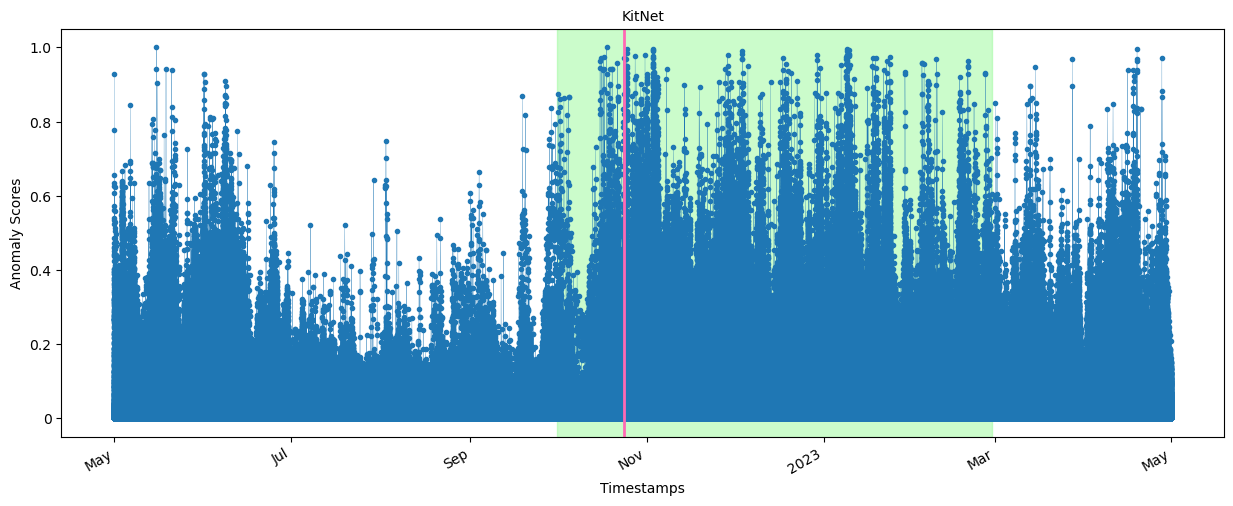

In [28]:
# Create the plot
import matplotlib.dates as mdates 
plt.figure(figsize=(15, 6))  # Increase the width of the plot
plt.plot(X_KitNet, Y_KitNet, linestyle='-',marker='.', linewidth=0.2, color="#1F77B4")  # Decrease line width for better visibility

yticks_positions = [0, 200, 400, 600, 800, 1000]

yticks_labels = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

plt.yticks(yticks_positions, yticks_labels)

# Highlighting 24th October for Diwali with a red vertical line
diwali_date = '2022-10-24'
diwali_timestamp = mdates.datestr2num(diwali_date)
plt.axvline(x=diwali_timestamp, color='hotpink', linestyle='-', linewidth=2)

# Highlighting the stubble burning timestamp with a light green background
start_date = '2022-10-01'
end_date = '2023-02-28'
start_timestamp = mdates.datestr2num(start_date) 
end_timestamp = mdates.datestr2num(end_date)      

plt.axvspan(start_timestamp, end_timestamp, color='palegreen', alpha=0.5, label='1st Oct - 28th Feb')

# Format the x-axis for dates
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)  # Adjust the number of ticks for better readability
formatter = mdates.ConciseDateFormatter(locator)

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Set labels and title
plt.xlabel('Timestamps')
plt.ylabel('Anomaly Scores')
#plt.ylim(0.499, 0.501)
plt.title('KitNet', fontsize=10)

# Show the plot
plt.show()

In [29]:
# import datetime
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# # Debug score_list_KitNet
# print(score_list_KitNet[:10])  # Debug first 10 values

# # Convert timestamps
# X_KitNet = [datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamp]
# Y_KitNet = score_list_KitNet

# # Create the plot
# plt.figure(figsize=(15, 6))  # Increase width
# plt.plot(X_KitNet, Y_KitNet, linestyle='-', marker='o', linewidth=1)  # Adjust linewidth

# # Format the x-axis
# locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
# formatter = mdates.ConciseDateFormatter(locator)
# plt.gca().xaxis.set_major_locator(locator)
# plt.gca().xaxis.set_major_formatter(formatter)
# plt.gcf().autofmt_xdate()

# # Set y-axis limits
# plt.ylim(min(Y_KitNet) - 0.01, max(Y_KitNet) + 0.01)

# # Add gridlines and threshold
# plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold')
# plt.grid(True, linestyle='--', alpha=0.7)

# # Set labels and title
# plt.xlabel('Timestamps')
# plt.ylabel('Anomaly Scores')
# plt.title('KitNet')
# plt.legend()

# # Show the plot
# plt.show()


# RRCF

In [30]:
def RobustRandomCutForest(da,datasetname=''):
    score_list_RRCF=[]
    model1 = pysad.models.RobustRandomCutForest(num_trees=10, shingle_size=10, tree_size=2048) # Model initialization
    preprocessor = InstanceUnitNormScaler()  # Normalizer
    postprocessor = RunningAveragePostprocessor(window_size=500)  # Running average postprocessor
    calibrator = GaussianTailProbabilityCalibrator(running_statistics=True, window_size=6400)
    
    global auc_rbcf
    auc_rbcf = AUROCMetric()
    score_gm = metrics.GeometricMean()
    score_recall = metrics.Recall()
    global actual_rbcf
    global pred_rbcf
    global gm_value_dict
    
    for x, y in da:
         if(y==False):
             y=0
         if(y==True):
             y=1
         values = list(x.values())
         numpy_array = np.array(values)
         X = preprocessor.fit_transform_partial(numpy_array)
         X = [0 if math.isnan(x) else x for x in X]
         anomaly_score = model1.fit_score_partial(X)    
         anomaly_score1 = postprocessor.fit_transform_partial(anomaly_score)
         calibrated_score1 = calibrator.fit_transform_partial(anomaly_score1)
         score_list_RRCF.append(anomaly_score)
         auc_rbcf.update(y, calibrated_score1)
         
         
         if(calibrated_score1>0.5):
             pred_rbcf.append(0)
         else:
             pred_rbcf.append(1)
         actual_rbcf.append(y)

    #print(score)
    score_gm=geometric_mean_score(np.array(actual_rbcf),np.array(pred_rbcf))
    score_recall=recall_score(np.array(actual_rbcf),np.array(pred_rbcf))
    auc_rbcf = round(sklearn.metrics.roc_auc_score(np.array(actual_rbcf),np.array(pred_rbcf)),4)
    print('-------------------------------------'+datasetname+': RobustRandomCutForest-------------------------------------------')
    accuracy = metrics.Accuracy()
    for yt, yp in zip(actual_rbcf, pred_rbcf):
        acc_rrcf.append(accuracy.get())
        accuracy.update(yt, yp)
    print(accuracy)
    print('ROCAUC:'+str(auc_rbcf))
    print(score_recall)
    print(score_gm)
    gm_value_dict['RRCF']=round(score_gm*100,2)
    #print(type(score_list_RRCF),type(max(score_list_RRCF)),max(score_list_RRCF))
    return score_list_RRCF/np.float64(max(score_list_RRCF))

In [31]:
score_list_RRCF=RobustRandomCutForest(stream.iter_array(np.array(x),np.array(y)),'Pollution_Final_data_8july.csv')

-------------------------------------Pollution_Final_data_8july.csv: RobustRandomCutForest-------------------------------------------
Accuracy: 72.00%
ROCAUC:0.6688
0.5651781686964367
0.6607266856340369


In [32]:
import datetime
X_RRCF = [datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamp]
Y_RRCF= score_list_RRCF

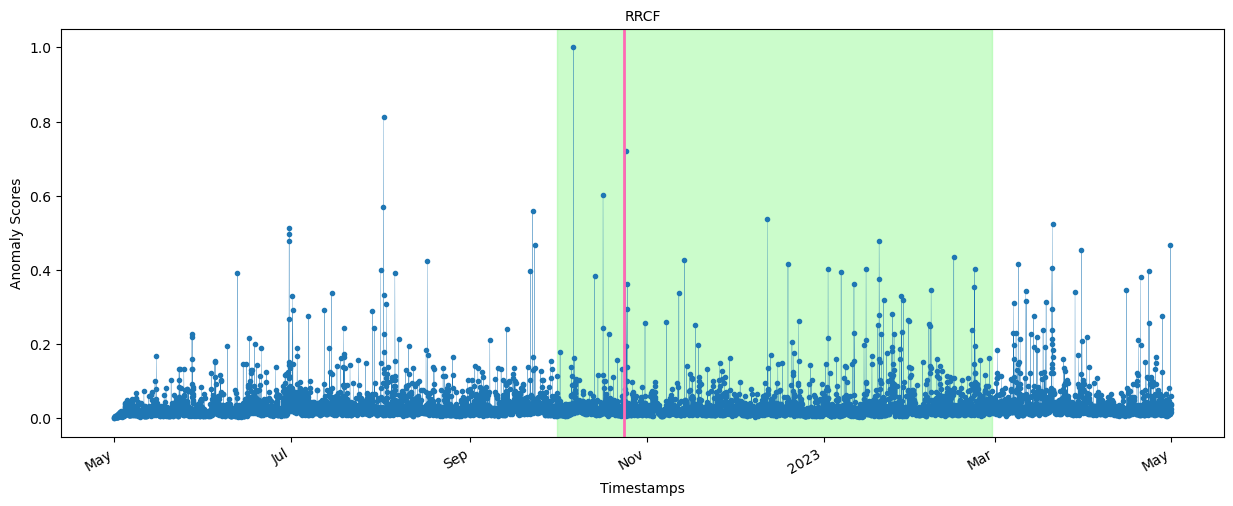

In [33]:
# Create the plot
import matplotlib.dates as mdates 
plt.figure(figsize=(15, 6))  # Increase the width of the plot
plt.plot(X_RRCF, Y_RRCF, linestyle='-',marker='.', linewidth=0.2)  # Decrease line width for better visibility

# Highlighting 24th October for Diwali with a red vertical line
diwali_date = '2022-10-24'
diwali_timestamp = mdates.datestr2num(diwali_date)
plt.axvline(x=diwali_timestamp, color='hotpink', linestyle='-', linewidth=2)

# Highlighting the stubble burning timestamp with a light green background
start_date = '2022-10-01'
end_date = '2023-02-28'
start_timestamp = mdates.datestr2num(start_date) 
end_timestamp = mdates.datestr2num(end_date)      

plt.axvspan(start_timestamp, end_timestamp, color='palegreen', alpha=0.5, label='1st Oct - 28th Feb')

# Format the x-axis for dates
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)  # Adjust the number of ticks for better readability
formatter = mdates.ConciseDateFormatter(locator)

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Set labels and title
plt.xlabel('Timestamps')
plt.ylabel('Anomaly Scores')
plt.title('RRCF', fontsize=10)

# Show the plot
plt.show()

# IForestASD

In [34]:
def IForestASD(da,datasetname=''):
    score_list_IForestASD=[]
    model1 = pysad.models.IForestASD() # Model initialization
    preprocessor = InstanceUnitNormScaler()  # Normalizer
    postprocessor = RunningAveragePostprocessor(window_size=500)  # Running average postprocessor
    calibrator = GaussianTailProbabilityCalibrator(running_statistics=True, window_size=6400)
    
    global auc_ifa
    auc_ifa = AUROCMetric()
    score_gm = metrics.GeometricMean()
    score_recall = metrics.Recall()
    global actual_ifa
    global pred_ifa
    global gm_value_dict
    
    for x, y in da:
         if(y==False):
             y=0
         if(y==True):
             y=1
         values = list(x.values())
         numpy_array = np.array(values)
         X = preprocessor.fit_transform_partial(numpy_array)
         X = [0 if math.isnan(x) else x for x in X]
         anomaly_score = model1.fit_score_partial(X)    
         anomaly_score1 = postprocessor.fit_transform_partial(anomaly_score)
         calibrated_score1 = calibrator.fit_transform_partial(anomaly_score1)
         score_list_IForestASD.append(anomaly_score)
         auc_ifa.update(y, calibrated_score1)
         
         
         if(calibrated_score1>0.5):
             pred_ifa.append(0)
         else:
             pred_ifa.append(1)
         actual_ifa.append(y)

    #print(score)
    score_gm=geometric_mean_score(np.array(actual_ifa),np.array(pred_ifa))
    score_recall=recall_score(np.array(actual_ifa),np.array(pred_ifa))
    auc_ifa = round(sklearn.metrics.roc_auc_score(np.array(actual_ifa),np.array(pred_ifa)),4)
    print('-------------------------------------'+datasetname+': IForestASD-------------------------------------------')
    accuracy = metrics.Accuracy()
    for yt, yp in zip(actual_ifa, pred_ifa):
        acc_ifsad.append(accuracy.get())
        accuracy.update(yt, yp)
    print (accuracy)
    print('ROCAUC:'+str(auc_ifa))
    print(score_recall)
    print(score_gm)
    gm_value_dict['IForestASD']=round(score_gm*100,2)
    score_list_IForestASD= (score_list_IForestASD+(-np.float64(min(score_list_IForestASD))))
    return score_list_IForestASD / np.float64(max(score_list_IForestASD))

In [35]:
score_list_IForestASD=IForestASD(stream.iter_array(np.array(x),np.array(y)),'Pollution_Final_data_8july.csv')

-------------------------------------Pollution_Final_data_8july.csv: IForestASD-------------------------------------------
Accuracy: 61.69%
ROCAUC:0.5938
0.5471357690572847
0.5919948438739371


In [36]:
import datetime
X_IForestASD = [datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamp]
Y_IForestASD= score_list_IForestASD

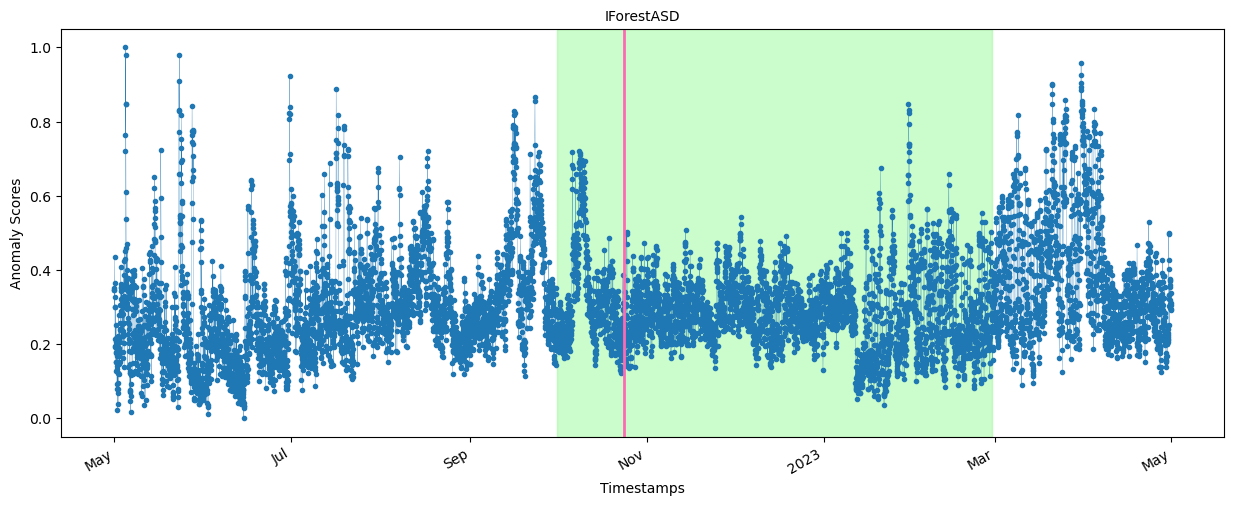

In [37]:
# Create the plot
import matplotlib.dates as mdates 
plt.figure(figsize=(15, 6))  # Increase the width of the plot
plt.plot(X_IForestASD, Y_IForestASD, linestyle='-',marker='.', linewidth=0.2)  # Decrease line width for better visibility

# Highlighting 24th October for Diwali with a red vertical line
diwali_date = '2022-10-24'
diwali_timestamp = mdates.datestr2num(diwali_date)
plt.axvline(x=diwali_timestamp, color='hotpink', linestyle='-', linewidth=2)

# Highlighting the stubble burning timestamp with a light green background
start_date = '2022-10-01'
end_date = '2023-02-28'
start_timestamp = mdates.datestr2num(start_date) 
end_timestamp = mdates.datestr2num(end_date)      

plt.axvspan(start_timestamp, end_timestamp, color='palegreen', alpha=0.5, label='1st Oct - 28th Feb')

# Format the x-axis for dates
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)  # Adjust the number of ticks for better readability
formatter = mdates.ConciseDateFormatter(locator)

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Set labels and title
plt.xlabel('Timestamps')
plt.ylabel('Anomaly Scores')
plt.title('IForestASD', fontsize=10)

# Show the plot
plt.show()

# KNNCAD

In [38]:
def KNNCAD(da,datasetname=''):
    score_list_KNNCAD=[]
    model1 = pysad.models.KNNCAD(100) # Model initialization
    preprocessor = InstanceUnitNormScaler()  # Normalizer
    postprocessor = RunningAveragePostprocessor(window_size=500)  # Running average postprocessor
    calibrator = GaussianTailProbabilityCalibrator(running_statistics=True, window_size=6400)
    
    global auc_kcad
    auc_kcad = AUROCMetric()
    score_gm = metrics.GeometricMean()
    score_recall = metrics.Recall()
    global actual_kcad
    global pred_kcad
    global gm_value_dict
    
    for x, y in da:
         if(y==False):
             y=0
         if(y==True):
             y=1
         values = list(x.values())
         numpy_array = np.array(values)
         X = preprocessor.fit_transform_partial(numpy_array)
         X = [0 if math.isnan(x) else x for x in X]
         anomaly_score = model1.fit_score_partial(X)    
         anomaly_score1 = postprocessor.fit_transform_partial(anomaly_score)
         calibrated_score1 = calibrator.fit_transform_partial(anomaly_score1)
         score_list_KNNCAD.append(anomaly_score)
         auc_kcad.update(y, calibrated_score1)
         
         
         if(calibrated_score1>0.5):
             pred_kcad.append(0)
         else:
             pred_kcad.append(1)
         actual_kcad.append(y)

    #print(score)
    score_gm=geometric_mean_score(np.array(actual_kcad),np.array(pred_kcad))
    score_recall=recall_score(np.array(actual_kcad),np.array(pred_kcad))
    auc_kcad = round(sklearn.metrics.roc_auc_score(np.array(actual_kcad),np.array(pred_kcad)),4)
    print('-------------------------------------'+datasetname+': KNNCAD-------------------------------------------')
    accuracy = metrics.Accuracy()
    for yt, yp in zip(actual_kcad, pred_kcad):
        acc_knncad.append(accuracy.get())
        accuracy.update(yt, yp)
    print(accuracy)
    print('ROCAUC:'+str(auc_kcad))
    print(score_recall)
    print(score_gm)
    gm_value_dict['KNNCAD']=round(score_gm*100,2)
    return score_list_KNNCAD

In [39]:
score_list_KNNCAD=KNNCAD(stream.iter_array(np.array(x),np.array(y)),'Pollution_Final_data_8july.csv')

-------------------------------------Pollution_Final_data_8july.csv: KNNCAD-------------------------------------------
Accuracy: 63.72%
ROCAUC:0.4962
0.21064501578709968
0.4057980470413566


In [40]:
import datetime
X_KNNCAD = [datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamp]
Y_KNNCAD= score_list_KNNCAD

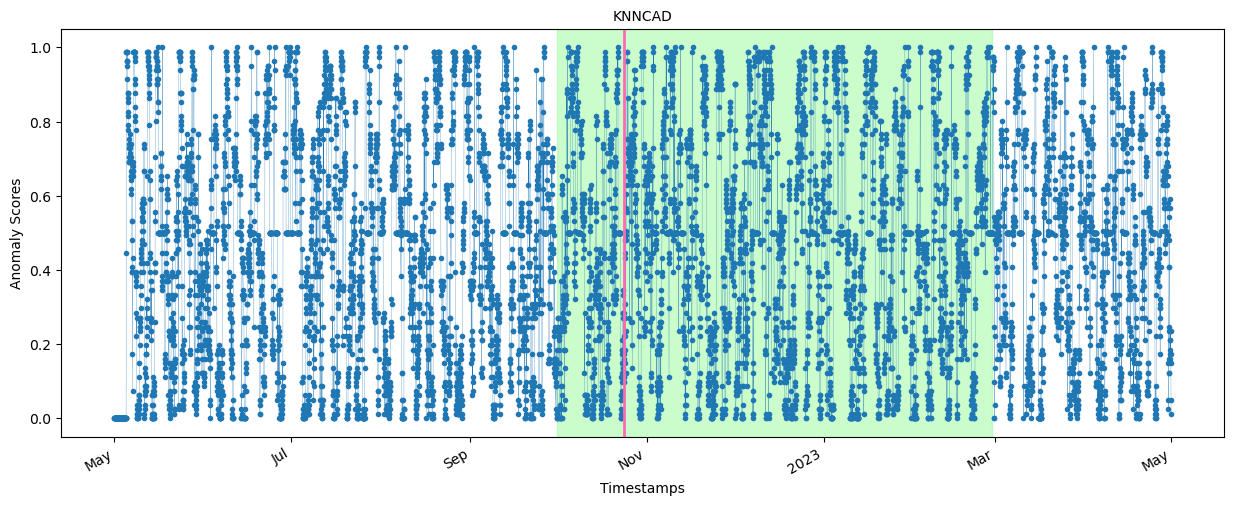

In [41]:
# Create the plot
import matplotlib.dates as mdates 
plt.figure(figsize=(15, 6))  # Increase the width of the plot
plt.plot(X_KNNCAD, Y_KNNCAD, linestyle='-',marker='.', linewidth=0.2)  # Decrease line width for better visibility

# Highlighting 24th October for Diwali with a red vertical line
diwali_date = '2022-10-24'
diwali_timestamp = mdates.datestr2num(diwali_date)
plt.axvline(x=diwali_timestamp, color='hotpink', linestyle='-', linewidth=2)

# Highlighting the stubble burning timestamp with a light green background
start_date = '2022-10-01'
end_date = '2023-02-28'
start_timestamp = mdates.datestr2num(start_date) 
end_timestamp = mdates.datestr2num(end_date)      

plt.axvspan(start_timestamp, end_timestamp, color='palegreen', alpha=0.5, label='1st Oct - 28th Feb')

# Format the x-axis for dates
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)  # Adjust the number of ticks for better readability
formatter = mdates.ConciseDateFormatter(locator)

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Set labels and title
plt.xlabel('Timestamps')
plt.ylabel('Anomaly Scores')
plt.title('KNNCAD', fontsize=10)

# Show the plot
plt.show()

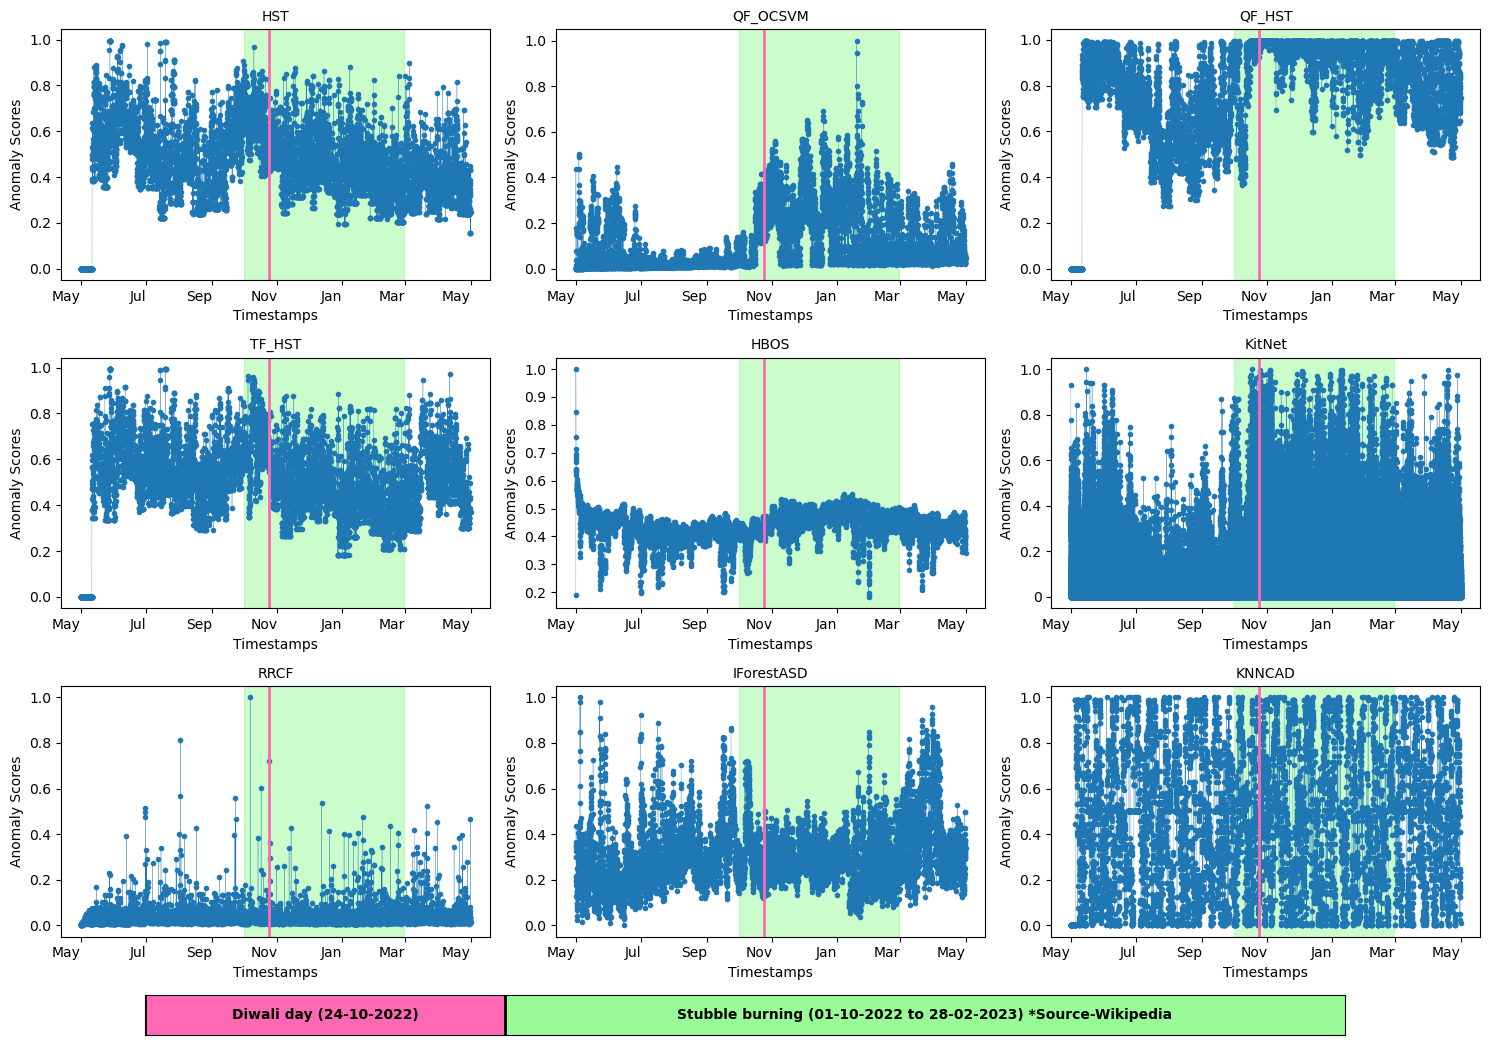

In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data lists (placeholders, replace with your actual data)
data = [
    (X_hst, Y_hst, 'HST'),
    (X_OCSVM, Y_OCSVM, 'QF_OCSVM'),
    (X_QF, Y_QF, 'QF_HST'),
    (X_TF, Y_TF, 'TF_HST'),
    (X_HBOS, Y_HBOS, 'HBOS'),
    (X_KitNet, Y_KitNet, 'KitNet'),
    (X_RRCF, Y_RRCF, 'RRCF'),
    (X_IForestASD, Y_IForestASD, 'IForestASD'),
    (X_KNNCAD, Y_KNNCAD, 'KNNCAD')
]

fig, axs = plt.subplots(3, 3, figsize=(15, 10))  # Create a 3x3 grid of subplots

# gs = fig.add_gridspec(4, 3, height_ratios=[9, 1, -1.44, -1.44], width_ratios=[9,9,0.5])

for i, (x, y, title) in enumerate(data):
    ax = axs[i // 3, i % 3]  # Determine the position in the grid
    ax.plot(x, y, linestyle='-', marker='.', linewidth=0.2, color="#1F77B4")

    if title == "KitNet":
        yticks_positions = [0, 200, 400, 600, 800, 1000]
        yticks_labels = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
        ax.set_yticks(yticks_positions, yticks_labels)

    # Highlighting the stubble burning timestamp with a lightgreen background
    start_date = '2022-10-01'
    end_date = '2023-02-28'
    start_timestamp = mdates.datestr2num(start_date) 
    end_timestamp = mdates.datestr2num(end_date)      
    ax.axvspan(start_timestamp, end_timestamp, color='palegreen', alpha=0.5, label='1st Oct - 28th Feb')    
    
    
    # Highlighting 5th October for Dussherah with a yellow vertical line
    #dussherah_date = '2022-10-05'
    #dussherah_timestamp = mdates.datestr2num(dussherah_date)
    #ax.axvline(x=dussherah_timestamp, color='yellow', linestyle='-', linewidth=2)
    
    # Highlighting 24th October for Diwali with a lightsalmon vertical line
    diwali_date = '2022-10-24'
    diwali_timestamp = mdates.datestr2num(diwali_date)
    ax.axvline(x=diwali_timestamp, color='hotpink', linestyle='-', linewidth=2)
    

    # Format the x-axis for dates
    locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
    # formatter = mdates.ConciseDateFormatter(locator)
    formatter = mdates.DateFormatter('%b')
    
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    # Rotate and align the tick labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha='right')
    
    # Set labels and title
    ax.set_xlabel('Timestamps')
    ax.set_ylabel('Anomaly Scores')
    ax.set_title(title, fontsize=10)

plt.subplots_adjust(hspace=0.33)

# plt.figure(figsize=(10, 0.6))

scale_ax = fig.add_axes([0.1, -0.04, 0.8, 0.04])  # [left, bottom, width, height] 

x_start = 0
x_end = 10

x_mid1 = 3
#x_mid2 = 7

#plt.axvspan(x_start, x_mid1, color = 'yellow')
scale_ax.axvspan(x_start, x_mid1, color = 'hotpink')
#plt.axvspan(x_mid1, x_mid2, color = 'red')
scale_ax.axvspan(x_mid1, x_end, color = 'palegreen')
#plt.axvspan(x_mid2, x_end, color = 'darkgreen')

#plt.axvline(x=x_mid1, color = 'black', linewidth=2)
scale_ax.axvline(x=x_start, color = 'black', linewidth=2)
scale_ax.axvline(x=x_mid1, color = 'black', linewidth=2)
#plt.axvline(x=x_mid2, color = 'black', linewidth=2)

#plt.text(1.5, 0.5, 'Dussehra', color = 'black', ha='center', va='center', fontsize=9)
scale_ax.text(1.5, 0.5, 'Diwali day (24-10-2022)', color = 'black', ha='center', va='center', fontsize=10, fontweight='bold')
scale_ax.text(6.5, 0.5, 'Stubble burning (01-10-2022 to 28-02-2023) *Source-Wikipedia', color = 'black', ha='center', va='center', fontsize=10, fontweight='bold')

scale_ax.set_xlim(x_start, x_end)
scale_ax.set_ylim(0, 1)

scale_ax.set_yticks([])
scale_ax.set_xticks([])


plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('timestamp_plot_Final_6.jpeg', bbox_inches='tight')
plt.show()


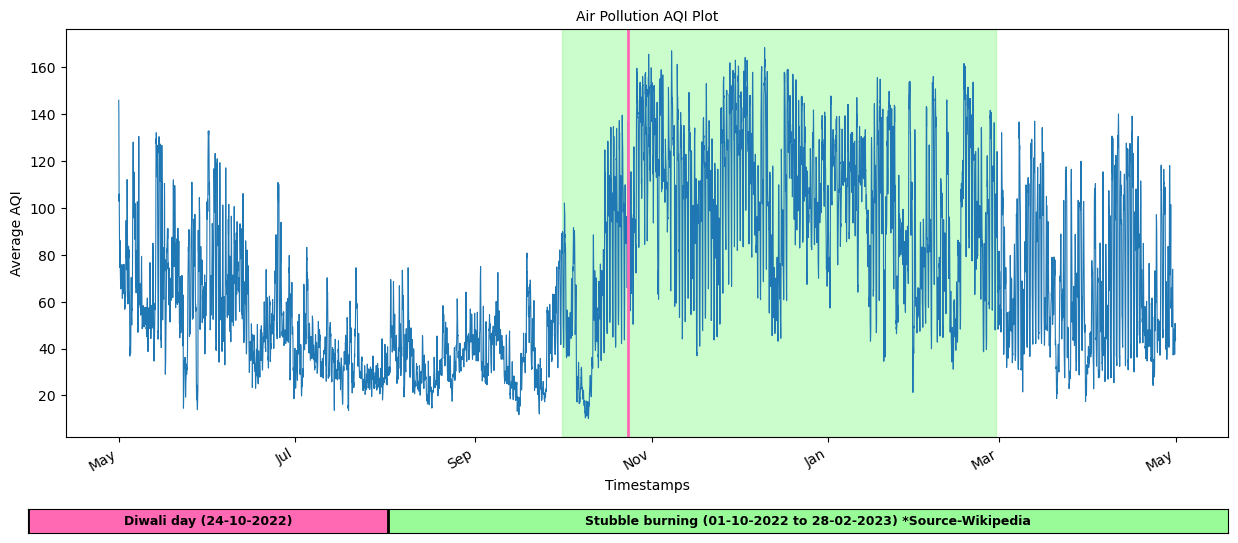

In [49]:
# Plotting a graph for Average AQI vs timestamps

timestamp_months = [datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in timestamp]
average_aqi = list(df1["Average AQI"])

# print(average_aqi)

fig = plt.figure(figsize=(15, 6))  # Increase the width of the plot
plt.plot(timestamp_months, average_aqi, linestyle='-', linewidth=0.8)  # Decrease line width for better visibility

# Highlighting 24th October for Diwali with a red vertical line
diwali_date = '2022-10-24'
diwali_timestamp = mdates.datestr2num(diwali_date)
plt.axvline(x=diwali_timestamp, color='hotpink', linestyle='-', linewidth=2)

# Highlighting the stubble burning timestamp with a light green background
start_date = '2022-10-01'
end_date = '2023-02-28'
start_timestamp = mdates.datestr2num(start_date) 
end_timestamp = mdates.datestr2num(end_date)      

plt.axvspan(start_timestamp, end_timestamp, color='palegreen', alpha=0.5, label='1st Oct - 28th Feb')

# Format the x-axis for dates
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)  # Adjust the number of ticks for better readability
formatter = mdates.ConciseDateFormatter(locator)

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

current_labels = [label.get_text() for label in plt.gca().get_xticklabels()]

# Replace "2023" with "Jan"
new_labels = ['Jan' if '2023' in label else label for label in current_labels]

# Set the new x-tick labels
plt.gca().set_xticklabels(new_labels)

# Set labels and title
plt.xlabel('Timestamps')
plt.ylabel('Average AQI')
plt.title('Air Pollution AQI Plot', fontsize=10)

scale_ax = fig.add_axes([0.1, 0.04, 0.8, 0.04])
# plt.figure(figsize=(10, 0.25))
x_start = 0
x_end = 10

x_mid1 = 3

scale_ax.axvspan(x_start, x_mid1, color = 'hotpink')
scale_ax.axvspan(x_mid1, x_end, color = 'palegreen')

scale_ax.axvline(x=x_start, color = 'black', linewidth=2)
scale_ax.axvline(x=x_mid1, color = 'black', linewidth=2)

scale_ax.text(1.5, 0.5, 'Diwali day (24-10-2022)', color = 'black', ha='center', va='center', fontsize=9, fontweight='bold')
scale_ax.text(6.5, 0.5, 'Stubble burning (01-10-2022 to 28-02-2023) *Source-Wikipedia', color = 'black', ha='center', va='center', fontsize=9, fontweight='bold')

plt.xlim(x_start, x_end)
plt.ylim(0, 1)

plt.yticks([])
plt.xticks([])
# Save plot
plt.savefig('Average_AQI_plot_3.jpeg', bbox_inches='tight')
# Show the plot
plt.show()


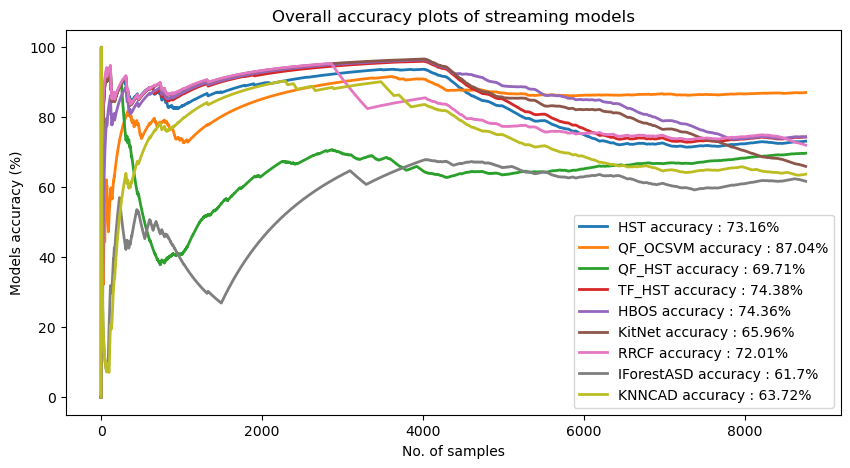

In [44]:
import matplotlib.pyplot as plt
percent=np.int64(100)
# Accuracy data
accuracy_data = [
    (acc_hst, 'HST'),
    (acc_ocsvm, 'QF_OCSVM'),
    (acc_qf, 'QF_HST'),
    (acc_tf, 'TF_HST'),
    (acc_hbos, 'HBOS'),
    (acc_kitnet, 'KitNet'),
    (acc_rrcf, 'RRCF'),
    (acc_ifsad, 'IForestASD'),
    (acc_knncad, 'KNNCAD')
]

plt.figure(figsize=(10, 5))
for acc, label in accuracy_data:
    acc_percentage = [a * 100 for a in acc]
    # print(acc_percentage)
    plt.plot(acc_percentage, label=label + f" accuracy : {round(acc_percentage[-1],2)}%", linestyle='-', linewidth=2) 
# Set labels and title
plt.xlabel('No. of samples')
plt.ylabel('Models accuracy (%)')
plt.title('Overall accuracy plots of streaming models')
# plt.ylim(0, 100)
plt.legend(loc='best')
plt.savefig('Pollution_accuracy.png')
# Show the plot
plt.show()

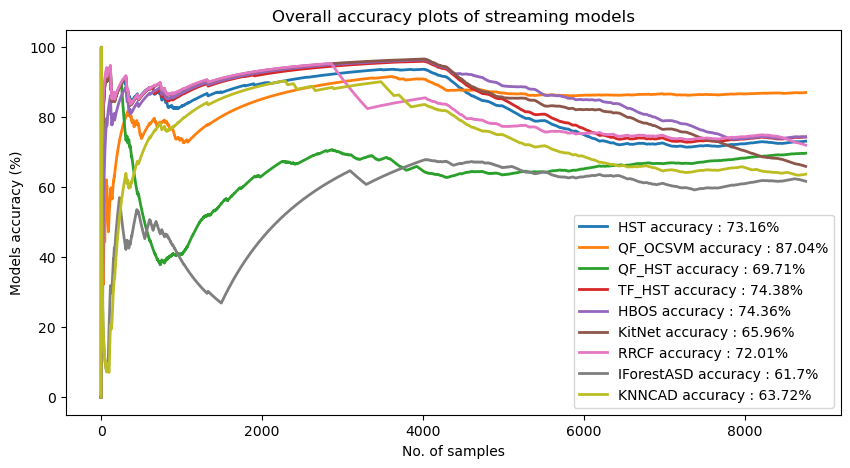

In [45]:
import matplotlib.pyplot as plt
import numpy as np

percent = np.int64(100)

# Accuracy data
accuracy_data = [
    (acc_hst, 'HST'),
    (acc_ocsvm, 'QF_OCSVM'),
    (acc_qf, 'QF_HST'),
    (acc_tf, 'TF_HST'),
    (acc_hbos, 'HBOS'),
    (acc_kitnet, 'KitNet'),
    (acc_rrcf, 'RRCF'),
    (acc_ifsad, 'IForestASD'),
    (acc_knncad, 'KNNCAD')
]

plt.figure(figsize=(10, 5))

for acc, label in accuracy_data:
    if acc:  # Check if the list is not empty
        acc_percentage = [a * 100 for a in acc]
        # print(acc_percentage)
        plt.plot(acc_percentage, label=label + f" accuracy : {round(acc_percentage[-1], 2)}%", linestyle='-', linewidth=2) 

# Set labels and title
plt.xlabel('No. of samples')
plt.ylabel('Models accuracy (%)')
plt.title('Overall accuracy plots of streaming models')
# plt.ylim(0, 100)
plt.legend(loc='best')
plt.savefig('Pollution_accuracy.png')
# Show the plot
plt.show()